In [351]:
# This is a notebook to analyse dataset for internet customers.

In [352]:
# Local all required packages
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib 
from random import random

In [353]:
# Add function definitions
def radarplot(df, norm_max=False):
    df = df.copy()
    if norm_max:
        df /= df.max()

    angles = np.linspace(0, 2 * np.pi, len(df.columns), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # close the plot

    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)

    for i in df.index:
        stats = df.loc[i, :].values
        stats = np.concatenate((stats, [stats[0]]))  # close the plot
        ax.plot(angles, stats, 'o-', linewidth=2, label=i)
        ax.fill(angles, stats, alpha=0.25)

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    columns = list(df.columns) + list(df.columns[:1])
    # print((angles * 180 / np.pi).shape, len(columns))
    ax.set_thetagrids(angles * 180 / np.pi, columns)
    ax.grid(True)
    return ax

In [358]:
# Load the dataset
data = pd.read_csv("Churn_Dataset.csv")
data[:5]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [359]:
# Clean the dataset
data['SeniorCitizen']= data['SeniorCitizen'].astype(str)
data["SeniorCitizen"].replace({"0": "No", "1": "Yes"}, inplace=True)
data['TotalCharges'] = data['TotalCharges'].replace(" ", 0)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])
index = pd.Index(data['customerID'].to_list())
data = data.set_index('customerID')

In [360]:
data[:5]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [314]:
# Extract the independent variables and save as X
X = data.iloc[:,:-1]
# Extract the dependent variable and save as Y
Y = data.iloc[:,-1]

In [315]:
# Encode the two-value columns using LabelEncoding and the multi-value columns using OneHotEncoding
# Iterate over columns and record the columns that need LabelEncoding
two_value_categorical = []
temp = []
for i in range(data.shape[1]-1):
    col_type = str(data.dtypes[i])
    col_name = str(data.columns[i])
    col_unique_values = str(data.nunique()[i])
    encoding_type = 'NoEncoding'
    if col_type == 'object':
        if col_unique_values == '2':
            encoding_type = 'LabelEncoding'
            two_value_categorical.append(col_name)
        else:
            encoding_type = 'OneHotEncoding'
    temp.append({"col_type":col_type, "col_name":col_name, "col_unique_values": col_unique_values, "encoding_type": encoding_type})

# Encode the two-value columns using LabelEncoding
LE1 = LabelEncoder()
for col_name in two_value_categorical:
    X[col_name] = LE1.fit_transform(X[col_name])
Y = pd.DataFrame(LE1.fit_transform(Y))
original_data_columns = pd.DataFrame.from_dict(temp)
original_data_columns

,col_type,col_name,col_unique_values,encoding_type
0,object,gender,2,LabelEncoding
1,object,SeniorCitizen,2,LabelEncoding
2,object,Partner,2,LabelEncoding
3,object,Dependents,2,LabelEncoding
4,int64,tenure,73,NoEncoding
5,object,PhoneService,2,LabelEncoding
6,object,MultipleLines,3,OneHotEncoding
7,object,InternetService,3,OneHotEncoding
8,object,OnlineSecurity,3,OneHotEncoding
9,object,OnlineBackup,3,OneHotEncoding


In [316]:
# Ecode all renaming columns using OneHotEncoding
X = pd.get_dummies(X)
encoded_data_columns = X.columns.values

In [317]:
# Get the encoded column names
pd.DataFrame(X.columns.values[:10])

,0
0,gender
1,SeniorCitizen
2,Partner
3,Dependents
4,tenure
5,PhoneService
6,PaperlessBilling
7,MonthlyCharges
8,TotalCharges
9,MultipleLines_No


In [318]:
X[:1]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0


In [319]:
Y[:1]

,0
0,0


In [320]:
# Split the dataset into training set and test set
X_train,X_test,Y_train,Y_test = train_test_split(X, Y,test_size=0.2,random_state=0)
X_train_Index = X_train.index.values.tolist()
X_test_Index = X_test.index.values.tolist()
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_train = pd.DataFrame(np.asarray(X_train).astype(np.float32), columns=X_train.columns.values)
Y_train = pd.DataFrame(np.asarray(Y_train).astype(np.float32), columns=Y_train.columns.values)
X_test = pd.DataFrame(np.asarray(X_test).astype(np.float32), columns=X_test.columns.values)
Y_test = pd.DataFrame(np.asarray(Y_test).astype(np.float32), columns=Y_test.columns.values)

In [321]:
# Normalise the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [322]:
pd.DataFrame(X_train[:5])

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-1.0,-0.439763,1.032476,-0.653215,1.612532,0.326254,-1.214659,0.674154,1.704761,1.035048,...,-0.806689,-0.526281,1.253566,-1.111228,-0.516093,1.793618,-0.531228,-0.518574,-0.712196,1.822238
1,-1.0,2.273954,-0.968546,-0.653215,-0.747907,-3.065099,0.823277,-0.614894,-0.709771,-0.966139,...,-0.806689,-0.526281,1.253566,0.899905,-0.516093,-0.557532,-0.531228,-0.518574,1.404108,-0.548776
2,-1.0,-0.439763,1.032476,1.530889,1.571835,0.326254,-1.214659,-1.335097,-0.208672,-0.966139,...,-0.806689,1.900125,-0.797724,-1.111228,-0.516093,1.793618,1.882432,-0.518574,-0.712196,-0.548776
3,1.0,-0.439763,1.032476,1.530889,0.025340,0.326254,0.823277,0.301578,0.053141,1.035048,...,-0.806689,-0.526281,1.253566,-1.111228,1.937635,-0.557532,-0.531228,-0.518574,-0.712196,1.822238
4,-1.0,-0.439763,1.032476,-0.653215,0.595101,0.326254,0.823277,1.128231,0.990579,-0.966139,...,1.239635,-0.526281,-0.797724,0.899905,-0.516093,-0.557532,-0.531228,-0.518574,1.404108,-0.548776


In [323]:
# Train Random Forest
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train,Y_train)

/tmp/ipykernel_14/645449655.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train,Y_train)


RandomForestRegressor(random_state=0)

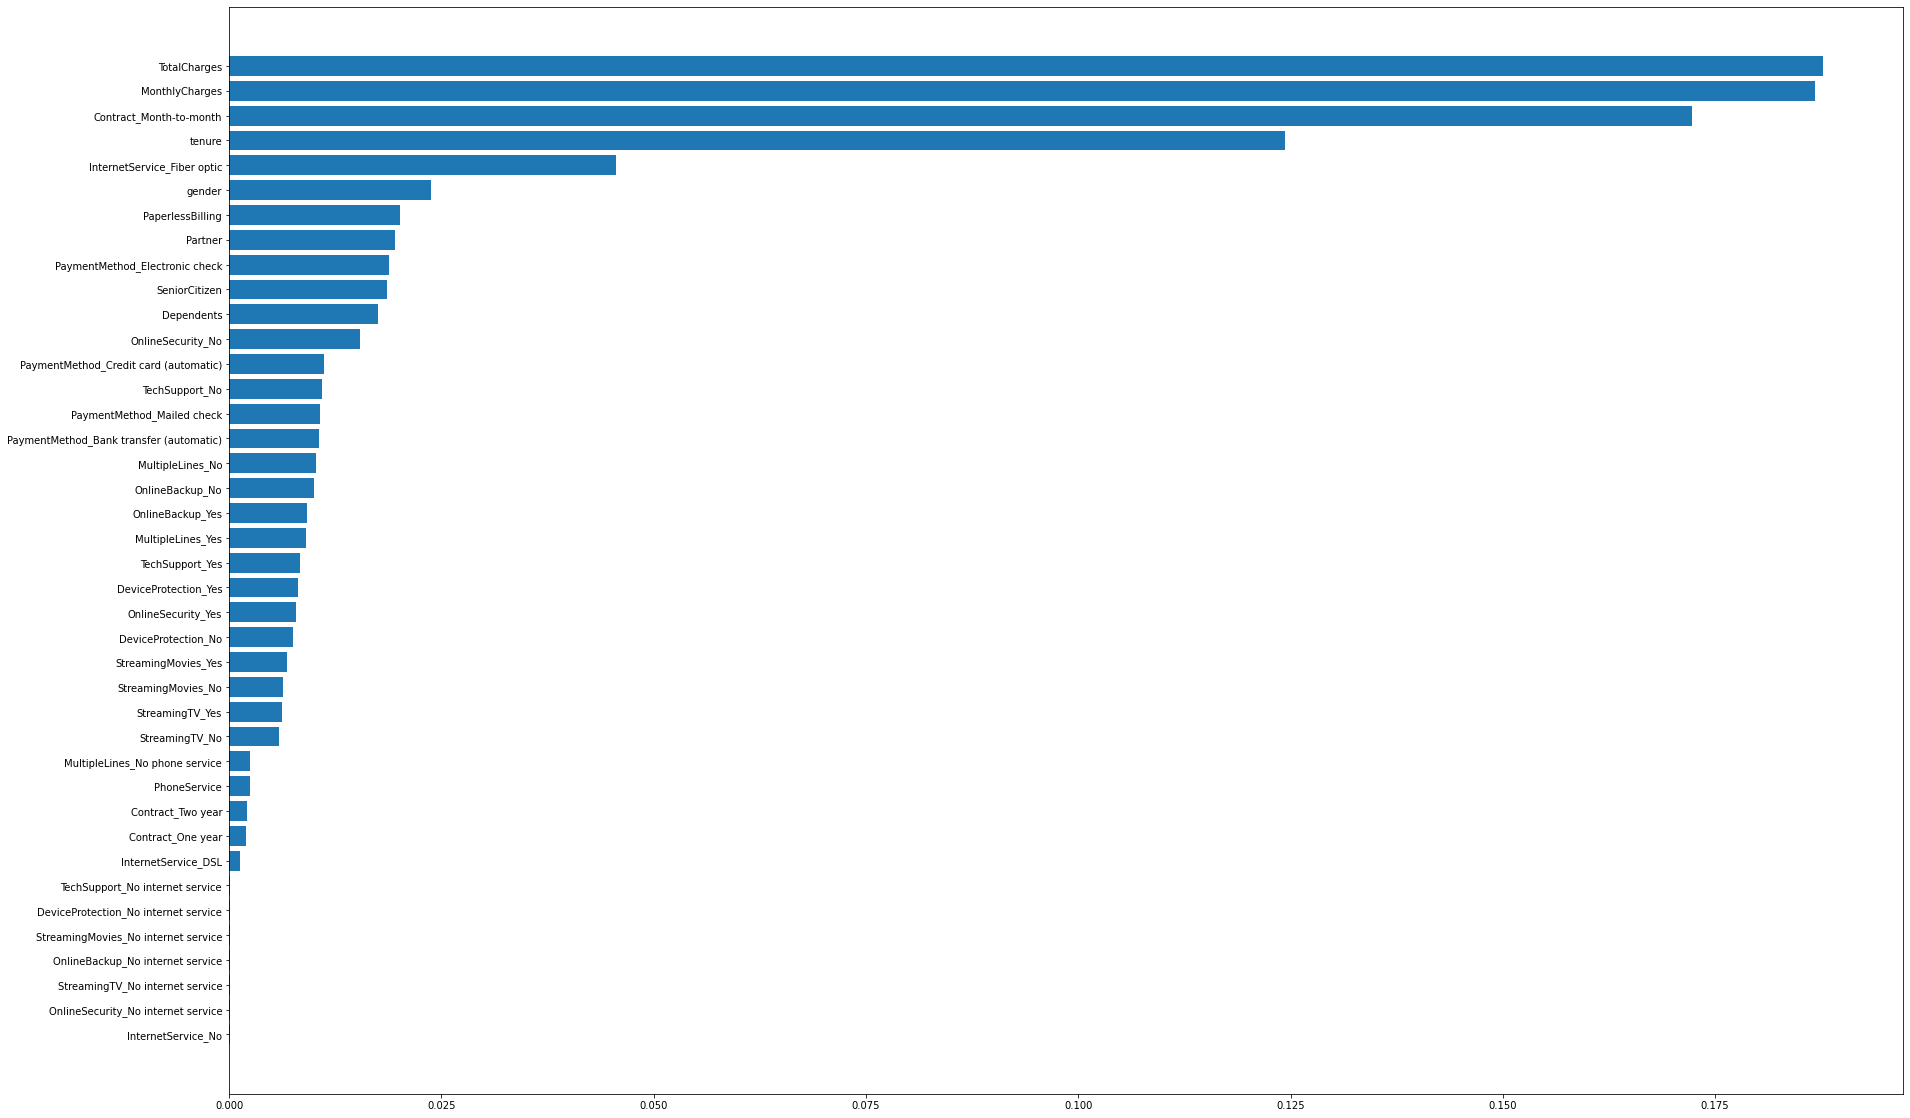

,feature,importance
0,InternetService_No,0.000058
1,OnlineSecurity_No internet service,0.000059
2,StreamingTV_No internet service,0.000066
3,OnlineBackup_No internet service,0.000078
4,StreamingMovies_No internet service,0.000095
5,DeviceProtection_No internet service,0.000101
6,TechSupport_No internet service,0.000120
7,InternetService_DSL,0.001260
8,Contract_One year,0.001954
9,Contract_Two year,0.002127


In [324]:
# Get features importance using Random Forest
features = encoded_data_columns
feature_indices = {v:i for i,v in enumerate(features)}
f_i = list(zip(features,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(20)
plt.rc('font', size=10)
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.show()
pd.DataFrame(f_i, columns = ["feature", "importance"])

In [325]:
# Train logistic regression
lreg = LogisticRegression(random_state = 0)
lreg.fit(X_train, Y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=0)

In [326]:
# Train artificial neural networks
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=50,activation="relu"))
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
optimizer = tf.keras.optimizers.SGD()
ann.compile(optimizer, loss="mse", metrics=["mae", "acc"])
history = ann.fit(X_train,Y_train,batch_size=32,epochs = 100)

Epoch 1/100
177/177 [==============================] - 1s 2ms/step - loss: 0.2035 - mae: 0.3790 - acc: 0.7054
Epoch 2/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1687 - mae: 0.3362 - acc: 0.7595
Epoch 3/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1570 - mae: 0.3167 - acc: 0.7701
Epoch 4/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1514 - mae: 0.3062 - acc: 0.7771
Epoch 5/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1481 - mae: 0.3004 - acc: 0.7845
Epoch 6/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1457 - mae: 0.2957 - acc: 0.7872
Epoch 7/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1439 - mae: 0.2919 - acc: 0.7884
Epoch 8/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1425 - mae: 0.2895 - acc: 0.7891
Epoch 9/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1415 - mae: 0.2879 - acc: 0.7916
Epoch 10/1

177/177 [==============================] - 0s 2ms/step - loss: 0.1303 - mae: 0.2656 - acc: 0.8124
Epoch 75/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1302 - mae: 0.2651 - acc: 0.8131
Epoch 76/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1302 - mae: 0.2655 - acc: 0.8133
Epoch 77/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1301 - mae: 0.2646 - acc: 0.8117
Epoch 78/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1301 - mae: 0.2649 - acc: 0.8133
Epoch 79/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1300 - mae: 0.2641 - acc: 0.8129
Epoch 80/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1299 - mae: 0.2646 - acc: 0.8138
Epoch 81/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1299 - mae: 0.2643 - acc: 0.8129
Epoch 82/100
177/177 [==============================] - 0s 2ms/step - loss: 0.1299 - mae: 0.2642 - acc: 0.8136
Epoch 83/100
1

In [327]:
# Get predictions for the test set
ypred = {}
ypred["ANN"] = [x[0] for x in ann.predict(X_test)]
ypred["LogisticRegression"] = [x[1] for x in lreg.predict_proba(X_test)]
ypred["RandomForests"] = rf.predict(X_test)

ANN
LogisticRegression
RandomForests


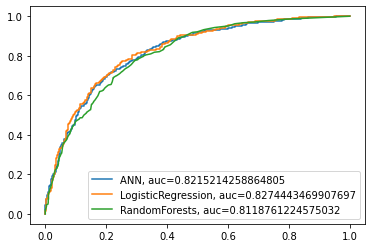

In [328]:
# Plot ROC and calculate AUC and save in results
results = {}
for method, predictions in ypred.items():
    print(method)
    fpr, tpr, _ = metrics.roc_curve(Y_test, predictions)
    auc = metrics.roc_auc_score(Y_test, predictions)
    plt.plot(fpr,tpr,label=method + ", auc="+str(auc))
    results[method] = [str(auc)]
plt.legend(loc=4)
plt.show()

In [329]:
# Calculate more performance metrics
for method, predictions in ypred.items():
    preds = []
    for x in predictions:
        if x <= 0.5:
            preds.append(0.0)
        else:
            preds.append(1.0)
    acc = accuracy_score(Y_test, preds )
    prec = precision_score(Y_test, preds )
    rec = recall_score(Y_test, preds )
    f1 = f1_score(Y_test, preds )
    f2 = fbeta_score(Y_test, preds, beta=2.0)
    results[method] = np.concatenate((results[method], [acc, prec, rec, f1, f2]))

In [330]:
results_df = pd.DataFrame(results, index=["auc", "acc", "prec", "rec", "f1", "f2"]).transpose()

In [331]:
results_df = results_df.apply(pd.to_numeric)

In [332]:
# Show performance metrics
results_df

,auc,acc,prec,rec,f1,f2
ANN,0.821521,0.792051,0.624585,0.510870,0.562033,0.530175
LogisticRegression,0.827444,0.797019,0.631410,0.535326,0.579412,0.552130
RandomForests,0.811876,0.776437,0.586885,0.486413,0.531947,0.503658


<PolarAxesSubplot:>

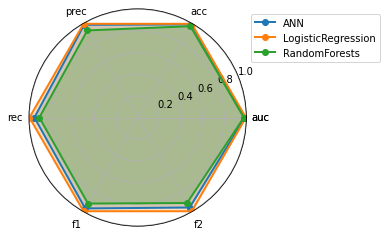

In [333]:
# Visualise the offline evaluation results
radarplot(results_df, norm_max=True)

In [334]:
# Calculate revenue when using each method to identify customers with 
# high propensity to churn and trying to keep them by offering promotion
# A promotion based on discount on monthly subscription fee offered with no locked-in contract
revenue = {}
revenue["with_promotion"] = {}
revenue["without_promotion"] = {}
for method,x in ypred.items():
    revenue["with_promotion"][method] = 0
    revenue["without_promotion"][method] = 0
for method,x in ypred.items():
    for i, index in enumerate(X_test_Index):
        pred_churn = ypred[method][i] >= 0.5
        true_churn = (Y_test.iloc[i,:] == 1.0).values[0]
        monthly_fee = data.loc[index][17]
        # No promotion. Revenue will come only from customers who will not churn
        if true_churn == False:
            revenue["without_promotion"][method] += monthly_fee
        # No promotion for customers who will probably not churn
        if pred_churn == False:
            # Revenue only from customers who do not churn
            if true_churn == False:
                revenue["with_promotion"][method] += monthly_fee
        # Promotion offered to all customers who will probably churn
        elif pred_churn == True:
            # If the customer were not going to churn, gonna accept the promotion anyway
            if true_churn == False:
                revenue["with_promotion"][method] += monthly_fee*0.8
            # Otherwise, at least half of the customers may accept the promotion and stay
            else:
                value = random()
                if value <= 0.5:
                    revenue["with_promotion"][method] += monthly_fee*0.8

In [335]:
revenue_df = pd.DataFrame(revenue)
revenue_df['uplift (%)'] = revenue_df.apply(lambda row: (row.with_promotion/row.without_promotion-1)*100, axis=1)

In [336]:
# Show promotion program performance
revenue_df

,with_promotion,without_promotion,uplift (%)
ANN,67778.24,63279.6,7.109147
LogisticRegression,67537.04,63279.6,6.727982
RandomForests,67244.50,63279.6,6.265684


Text(0, 0.5, 'Uplift(%)')

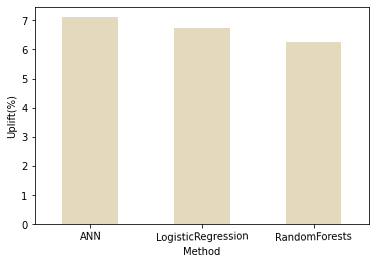

In [337]:
# Visualise uplifts
revenue_df.iloc[:,2].plot(
    kind = 'bar',
    rot = 1, color ='#e3dabd' )
plt.xlabel("Method")
plt.ylabel("Uplift(%)")

In [338]:
# A promotion based on discount on yearly subscription fee offered with locked-in contract
revenue = {}
revenue["with_promotion"] = {}
revenue["without_promotion"] = {}
for method,x in ypred.items():
    revenue["with_promotion"][method] = 0
    revenue["without_promotion"][method] = 0
for method,x in ypred.items():
    for i, index in enumerate(X_test_Index):
        pred_churn = ypred[method][i] >= 0.5
        true_churn = (Y_test.iloc[i,:] == 1.0).values[0]
        monthly_fee = data.loc[index][17]
        contract_type = data.loc[index][14]
        # No promotion. Revenue will come only from customers who will not churn
        # Assumption: these customers will not churn for the next 12 months
        if true_churn == False:
            revenue["without_promotion"][method] += 12*monthly_fee
        # No promotion for customers who will probably not churn
        if pred_churn == False:
            # Revenue only from customers who do not churn
            # Assumption: these customers will not churn for the next 12 months
            if true_churn == False:
                revenue["with_promotion"][method] += 12*monthly_fee
        # Promotion offered to all customers who will probably churn and are on monthly contract
        elif pred_churn == True:
            if contract_type == "Month-to-month":
                # If the customer were not going to churn, gonna accept the promotion anyway
                if true_churn == False:
                    revenue["with_promotion"][method] += 12*monthly_fee*0.6
                # Otherwise, at least half of the customers may accept the promotion and stay
                else:
                    value = random()
                    if value <= 0.5:
                        revenue["with_promotion"][method] += 12*monthly_fee*0.6

In [339]:
revenue_df = pd.DataFrame(revenue)
revenue_df['uplift (%)'] = revenue_df.apply(lambda row: (row.with_promotion/row.without_promotion-1)*100, axis=1)

In [340]:
revenue_df

,with_promotion,without_promotion,uplift (%)
ANN,774758.76,759355.2,2.028505
LogisticRegression,777718.20,759355.2,2.418236
RandomForests,760996.80,759355.2,0.216183


Text(0, 0.5, 'Uplift(%)')

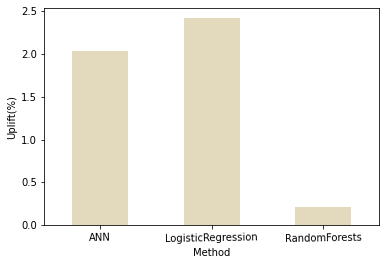

In [341]:
# Visualise uplifts
revenue_df.iloc[:,2].plot(
    kind = 'bar',
    rot = 1, color ='#e3dabd' )
plt.xlabel("Method")
plt.ylabel("Uplift(%)")